In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col
from pyspark.ml.feature import Imputer

In [ ]:
import warnings

spark = SparkSession.builder \
    .appName("Car Crash Prediction Model") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.sql.debug.maxToStringFields", "200") \
    .getOrCreate()
    
spark.sparkContext.setLogLevel("ERROR")


25/04/06 12:07:04 WARN Utils: Your hostname, Glorias-MacBook-Air-10.local resolves to a loopback address: 127.0.0.1; using 10.0.0.117 instead (on interface en0)
25/04/06 12:07:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/06 12:07:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/06 12:07:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
merged_all_df = spark.read.parquet("data/parquet/final_real_df")

# Compute a combined risk score
merged_all_df = merged_all_df.withColumn(
    "combined_risk_score",
    (col("total_crashes") * col("avg_severity_weight"))
)

quantiles = merged_all_df.approxQuantile("combined_risk_score", [0.5, 0.8], 0.01)
q50, q80 = quantiles

# Define risk levels based on combined score
merged_all_df = merged_all_df.withColumn(
    "hotspot_risk_level",
    when((col("combined_risk_score") > q80), "high")
    .when((col("combined_risk_score") > q50) & (col("combined_risk_score") <= q80), "moderate")
    .otherwise("low")
)

merged_all_df.groupBy("hotspot_risk_level").count().show()

+------------------+-----+
|hotspot_risk_level|count|
+------------------+-----+
|          moderate| 7691|
|               low|12788|
|              high| 5392|
+------------------+-----+



#1 Baseline Model: RandomForestClassifier

In [4]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.feature import StandardScaler


# Step 1: StringIndex all categorical columns (and the target)
categorical_columns = ['municipality', 'weather', 'season', 'road_condition', 'last_weather', 'last_weather_description']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='skip') for col in categorical_columns]

# Step 2: OneHotEncode all indexed categorical columns
encoder = OneHotEncoder(inputCols=[col + "_index" for col in categorical_columns], 
                        outputCols=[col + "_ohe" for col in categorical_columns])

# Step 3: StringIndex the target variable
indexer_target = StringIndexer(inputCol="hotspot_risk_level", outputCol="label", handleInvalid='skip')

# Step 4: Assemble all features into a single vector
numerical_columns = ['lat_bin', 'lon_bin', 'avg_speed_limit', 'avg_total_vehicles_involved', 
                     'avg_total_casualty', 'pct_intersection_crash', 'pct_pedestrian_involved', 'pct_distraction_involved', 
                     'pct_drug_involved', 'pct_impaired_involved', 'pct_speed_involved', 'pct_is_weekend', 'pct_is_rush_hour', 
                     'avg_temp', 'avg_visibility', 'avg_clouds', 'max_rain', 'max_snow', 'avg_speed', 'avg_flow_speed', 
                     'avg_travel_time', 'avg_flow_travel_time', 'avg_speed_diff', 'had_closure']

feature_cols = numerical_columns + [col + "_ohe" for col in categorical_columns]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Apply assembler first, then fit and apply scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Split data into training and test sets
train_df, test_df = merged_all_df.randomSplit([0.8, 0.2], seed=42)

# Step 5: Create the RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=100, maxDepth=10, seed=42)

# Step 6: Build the pipeline
pipeline_rf = Pipeline(stages=indexers + [indexer_target, encoder, assembler, scaler, rf])


# Step 7: Train the model
rfc_model = pipeline_rf.fit(train_df)


# Step 8: Make predictions
predictions_rf = rfc_model.transform(test_df)


# Step 9: Evaluate the model
# Create evaluators for Precision, Recall, and F1 Score
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Calculate accuracy, precision, recall, and F1 score
accuracy = evaluator_accuracy.evaluate(predictions_rf)
precision = evaluator_precision.evaluate(predictions_rf)
recall = evaluator_recall.evaluate(predictions_rf)
f1_score = evaluator_f1.evaluate(predictions_rf)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Model Accuracy: 0.8243
Precision: 0.8190
Recall: 0.8243
F1 Score: 0.8175


In [ ]:
# Save RFC Model
pipeline_rf.write().overwrite().save("model/rfc_pipeline")

rfc_model.write().overwrite().save("model/rfc_model")

/Users/gloriamo/Desktop/van-crash-predictor/venv/lib/python3.13/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
DenseMatrix([[2344.,   97.,    6.],
             [ 375.,  929.,  221.],
             [   5.,  184.,  892.]])


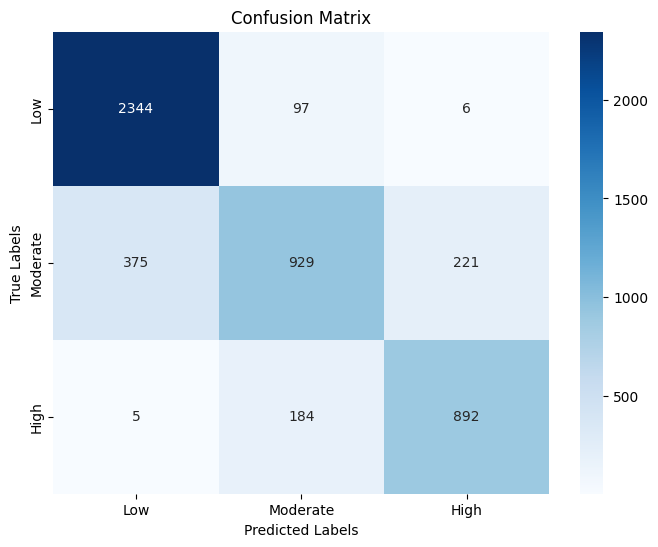

In [11]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract the prediction and label columns
prediction_and_labels = predictions_rf.select("prediction", "label").rdd

# Create the confusion matrix
metrics = MulticlassMetrics(prediction_and_labels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix()
print("Confusion Matrix:")
print(confusion_matrix)

# Get the confusion matrix as a DenseMatrix
confusion_matrix_arr = metrics.confusionMatrix().toArray()

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_arr, annot=True, fmt="g", cmap="Blues", xticklabels=["Low", "Moderate", "High"], yticklabels=["Low", "Moderate", "High"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [12]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert prediction + label to RDD of (prediction, label)
predictionAndLabels = predictions_rf.select("prediction", "label") \
    .rdd.map(lambda row: (float(row.prediction), float(row.label)))

# Create metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Get all labels
labels = predictions_rf.select("label").distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()

# Compute metrics
for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1 = metrics.fMeasure(label)
    
    print(f"Class {int(label)}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}\n")

/Users/gloriamo/Desktop/van-crash-predictor/venv/lib/python3.13/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0:
  Precision: 0.8605
  Recall:    0.9579
  F1 Score:  0.9066

Class 1:
  Precision: 0.7678
  Recall:    0.6092
  F1 Score:  0.6793

Class 2:
  Precision: 0.7971
  Recall:    0.8252
  F1 Score:  0.8109



In [13]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Create a parameter grid for Random Forest
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

# 5-fold Cross-validation
crossval = CrossValidator(estimator=pipeline_rf, 
                          estimatorParamMaps=param_grid, 
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy"), 
                          numFolds=5)  

# Fit the model
cv_model = crossval.fit(train_df)

# Evaluate the best model
best_model = cv_model.bestModel
predictions = cv_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Cross-validated Model Accuracy: {accuracy:.4f}")



Cross-validated Model Accuracy: 0.8526


In [16]:
# Save hyper-param tuned CV model
cv_model.write().overwrite().save("model/cv_model")

best_model.write().overwrite().save("model/best_rfc_model")

/Users/gloriamo/Desktop/van-crash-predictor/venv/lib/python3.13/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
DenseMatrix([[2.341e+03, 1.020e+02, 4.000e+00],
             [2.570e+02, 1.091e+03, 1.770e+02],
             [1.000e+00, 2.040e+02, 8.760e+02]])


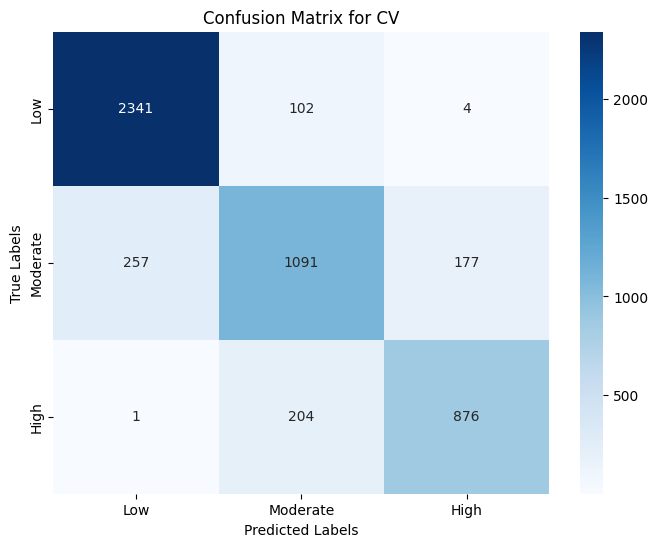

In [17]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract the prediction and label columns
prediction_and_labels = predictions.select("prediction", "label").rdd

# Create the confusion matrix
metrics = MulticlassMetrics(prediction_and_labels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix()
print("Confusion Matrix:")
print(confusion_matrix)

# Extract the prediction and label columns
prediction_and_labels = predictions.select("prediction", "label").rdd

# Create the confusion matrix
metrics = MulticlassMetrics(prediction_and_labels)

# Get the confusion matrix as a DenseMatrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues", xticklabels=["Low", "Moderate", "High"], yticklabels=["Low", "Moderate", "High"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CV')
plt.show()


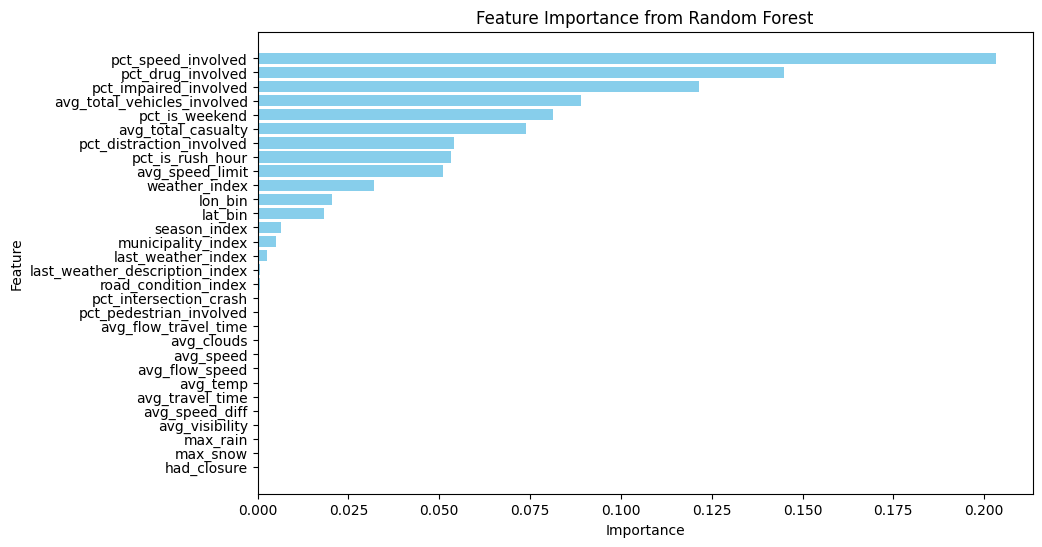

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Get the trained random forest model
rf_model = rfc_model.stages[-1]

# Get feature importances
feature_importances = rf_model.featureImportances

# Combine feature names with their importances
features = numerical_columns + [col + "_index" for col in categorical_columns]
feature_importance_dict = dict(zip(features, feature_importances))

# Sort the feature importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and their corresponding importance values
sorted_features = [item[0] for item in sorted_feature_importance]
sorted_importances = [item[1] for item in sorted_feature_importance]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis() 
plt.show()

In [19]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming numerical_columns and categorical_columns are already defined
# Get feature importances
feature_importances = rf_model.featureImportances

# List of features with their importance
features_with_importance = list(zip(numerical_columns + [col + "_index" for col in categorical_columns], feature_importances))

# Sort the features by importance in descending order
sorted_features = sorted(features_with_importance, key=lambda x: x[1], reverse=True)

# Select top N important features (you can adjust N based on your needs)
top_n_features = [feature for feature, importance in sorted_features[:10]]  # For example, top 10 features

# Now, filter the data to include only the selected top features
# Ensure the list of top_n_features includes both numerical and categorical columns (with indexing)
numeric_features = numerical_columns + [col + "_index" for col in categorical_columns]

# Assembling features using VectorAssembler
assembler = VectorAssembler(inputCols=top_n_features, outputCol="features")

# Optionally scale the features (if you want to scale the features for Random Forest)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Create a Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=100, maxDepth=10, maxBins=32)

# Define the pipeline with assembling, scaling, and classification stages
pipeline = Pipeline(stages=indexers + [indexer_target, assembler, scaler, rf])

# Fit the model
model_retrained = pipeline.fit(train_df)

# Make predictions
predictions_retrained = model_retrained.transform(test_df)

# Evaluate the retrained model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_retrained = evaluator.evaluate(predictions_retrained)
print(f"Retrained Model Accuracy (using top {len(top_n_features)} features): {accuracy_retrained:.4f}")


Retrained Model Accuracy (using top 10 features): 0.8638


In [20]:
model_retrained.write().overwrite().save("model/feature_importance_model")

In [48]:
predictions_retrained = predictions_retrained.withColumnRenamed("lat_bin", "latitude") \
                        .withColumnRenamed("lon_bin", "longitude")
        
predictions_retrained.select("latitude", "longitude", "municipality", "hotspot_risk_level", "probability").show()


+--------+---------+------------+------------------+--------------------+
|latitude|longitude|municipality|hotspot_risk_level|         probability|
+--------+---------+------------+------------------+--------------------+
|  48.382| -123.709|       sooke|               low|[0.94541149348575...|
|  48.394| -123.636|       sooke|               low|[0.95887728305354...|
|  48.411| -123.357|    victoria|               low|[0.99036517384909...|
|  48.418| -123.372|    victoria|               low|[0.99383778260092...|
|  48.421|  -123.36|    victoria|               low|[0.99951363544213...|
|  48.423| -123.363|    victoria|               low|[0.98098466671021...|
|  48.425| -123.368|    victoria|               low|[0.76372287402769...|
|  48.426| -123.356|    victoria|               low|[0.95848321354778...|
|  48.429| -123.337|    victoria|          moderate|[0.25441697165174...|
|   48.43| -123.503|     colwood|              high|[0.04934886995116...|
|   48.43| -123.503|     colwood|     

In [ ]:
from pyspark.sql import functions as F

# Define a mapping from prediction indices to 'hotspot_risk_level'
mapping = {0.0: 'low', 1.0: 'moderate', 2.0: 'high'}

# Create a new column with mapped hotspot_risk_level based on prediction
predictions_mapped = predictions_retrained.withColumn(
    "predicted_hotspot_risk_level", 
    F.when(F.col("prediction") == 0.0, 'low')
     .when(F.col("prediction") == 1.0, 'moderate')
     .when(F.col("prediction") == 2.0, 'high')
     .otherwise("unknown") 
)

# Show the updated dataframe
#predictions_mapped.select("hotspot_risk_level", "prediction", "predicted_hotspot_risk_level", "probability").filter(col("predicted_hotspot_risk_level") == "high").show()

Model 2: XGBoost

In [69]:
import xgboost as xgb
import numpy as np
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler

# Step 1: StringIndex all categorical columns (and the target)
categorical_columns = ['municipality', 'weather', 'season', 'road_condition', 'last_weather', 'last_weather_description']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='skip') for col in categorical_columns]

# Step 2: OneHotEncode all indexed categorical columns
encoder = OneHotEncoder(inputCols=[col + "_index" for col in categorical_columns], 
                        outputCols=[col + "_ohe" for col in categorical_columns])

# Step 3: StringIndex the target variable
indexer_target = StringIndexer(inputCol="hotspot_risk_level", outputCol="label", handleInvalid='skip')

# Step 4: Assemble all features into a single vector
numerical_columns = ['lat_bin', 'lon_bin', 'avg_speed_limit', 'avg_total_vehicles_involved', 
                     'avg_total_casualty', 'pct_intersection_crash', 'pct_pedestrian_involved', 'pct_distraction_involved', 
                     'pct_drug_involved', 'pct_impaired_involved', 'pct_speed_involved', 'pct_is_weekend', 'pct_is_rush_hour', 
                     'avg_temp', 'avg_visibility', 'avg_clouds', 'max_rain', 'max_snow', 'avg_speed', 'avg_flow_speed', 
                     'avg_travel_time', 'avg_flow_travel_time', 'avg_speed_diff', 'had_closure']

feature_cols = numerical_columns + [col + "_ohe" for col in categorical_columns]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Step 5: Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Step 6: Build the pipeline
pipeline = Pipeline(stages=indexers + [indexer_target, encoder, assembler, scaler])

# Step 7: Split data into training and test sets
train_df, test_df = merged_all_df.randomSplit([0.8, 0.2], seed=42)

# Step 8: Fit the pipeline
pipeline_model = pipeline.fit(train_df)

# Step 9: Transform the data
train_data = pipeline_model.transform(train_df)
test_data = pipeline_model.transform(test_df)

# Step 10: Prepare XGBoost data in DMatrix format
train_features = np.array([x.toArray() for x in train_data.select("scaled_features").rdd.map(lambda row: row[0]).collect()])
train_labels = np.array(train_data.select("label").rdd.map(lambda row: row[0]).collect())

test_features = np.array([x.toArray() for x in test_data.select("scaled_features").rdd.map(lambda row: row[0]).collect()])
test_labels = np.array(test_data.select("label").rdd.map(lambda row: row[0]).collect())

# Create DMatrix
dtrain = xgb.DMatrix(train_features, label=train_labels)
dtest = xgb.DMatrix(test_features, label=test_labels)

# Step 11: Set XGBoost parameters
params = {
    'objective': 'multi:softmax', 
    'num_class': 3,
    'eval_metric': 'merror'
}

# Step 12: Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Step 13: Make predictions
predictions = xgb_model.predict(dtest)

# Step 14: Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9064
Precision: 0.9063
Recall: 0.9064
F1 Score: 0.9063


HEATMAP VISUALIZATION

In [66]:
# Convert predictions to Pandas
heatmap_df = predictions_mapped.select("latitude", "longitude", "predicted_hotspot_risk_level").toPandas()

# Map predictions back to labels
label_map = {0.0: "low", 1.0: "moderate", 2.0: "high"}
heatmap_df["hotspot_risk_level"] = heatmap_df["predicted_hotspot_risk_level"].map(label_map)

# Assign weight (optional: to enhance heatmap intensity)
risk_weight = {"low": 1, "moderate": 3, "high": 5}
heatmap_df["weight"] = heatmap_df["predicted_hotspot_risk_level"].map(risk_weight)

In [68]:
import folium
from folium.plugins import HeatMap

# Initialize map centered around average lat/lon
center_lat = heatmap_df["latitude"].mean()
center_lon = heatmap_df["longitude"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Prepare data: [lat, lon, weight]
heat_data = heatmap_df[["latitude", "longitude", "weight"]].values.tolist()

# Add heatmap layer
HeatMap(heat_data, radius=15, blur=10, max_zoom=13).add_to(m)

# Save and display
m.save("hotspot_heatmap.html")
m